# Hyper-parameter tuning of multi task learning (MTL) based VGG model with ImageNet weights for gender, age group and race classifications (version 2)

This code performs a grid serch to find the best combination of batch size and learning rate that privide the highest combined validation accuracy for age group, gender and race classifications for a MTL based VGG-model. This grid serach looks thorough batch sizes [16, 32, 64, 128] and learning rates [1e-6, 1e-5, 1e-4, 1e-3] over a 10 epoch period on training and validation data-subsets (10% and 5% of UTKFace data used in this work).

Here, multi task learning is applied to train a deep network for age group, gender and race classifications. A VGG16 convolutional base (Simonyan and Zisserman, 2015) trained on ImageNet (Deng, 2009) is connected to three separate fully connected (FC) layers along with output layers to achieve the respective classifications. Through transfer learning, the weights of trained model on ImageNet is loaded as the convolutional base which is fully frozen except block 5. All FCs and block 5 of the VGG base are allowed to train. <br>

Model Summary: <br>
Running frozen VGG16 (except block 5) conv base + 3 x {[128] FC layer + [out layer]} for tuning of hyper-parameters such as batch size and learning rate where out layer has 2, 5, 5 nodes for age group, gender and race classifications respectively.

## 1. Dataset
In this section, an exploratory data analysis (EDA) of the UTKFace data used in this study is carried out.
<br> It is required to install keras-cv to apply random rotations in augmenting data.

In [ ]:
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 58.8 MB/s eta 0:00:00


The following shows the required imports to run this colab file.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import cv2
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses
from keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import set_random_seed
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import keras_cv
from keras.utils import plot_model
from tensorflow import keras
from tensorflow.keras.callbacks import Callback

Now, the seed is set to a random integer so that same sequence of random numbers are generated each time the programme is run. Therefore, this ensures that the results are reproducible.

In [ ]:
# Setting the seed
seed = 42
set_random_seed(seed)
np.random.seed(42)

Here, my Google Drive is connected to this Colab file.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Below folder contains the cropped faces of the UTKFace data (Song, Zhang and Qi, 2017) from the "RetinaFace" algorithm (Deng et al., 2020). This deep learning based algorithm was used to extract faces with a fixed spatial resolution of 100 x 100 and save them in RGB image form.

In [ ]:
folder_path = "/content/drive/My Drive/UTKFace_retina_cropped_100x100"

Following shows the total number of facial images stored in the folder.

In [ ]:
cnt = 0
for file in sorted(os.listdir(folder_path)):  # Sort file list
  file_path = os.path.join(folder_path,file)
  cnt = cnt + 1

print(f"Number of face images: {cnt}")

Number of face images: 23561


The following code creates a donut chart on gender and race percentages in UTKFace dataset used in this work. The outer circle shows the gender distribution as a percentage and the inner circle shows the race percentages associated with each gender.

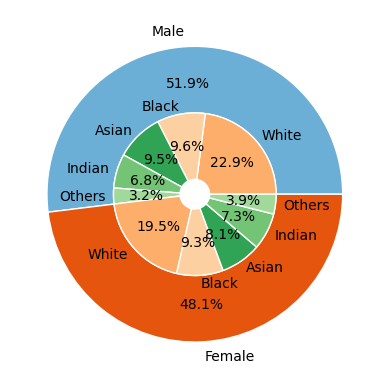

In [ ]:
# age: is an integer from 0 to 116, indicating the age
# gender: is either 0 (male) or 1 (female)
# race: is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

column_names = ['Age', 'Gender', 'Race']
records = []

for file in os.listdir(folder_path):
  records.append(file.split('_')[:-1])

DFrame=pd.DataFrame(records, columns=column_names).astype(int)

# EDA: Donut chart
fig, ax = plt.subplots()
cmap = plt.colormaps["tab20c"]
outer_colors = cmap([1,4])
inner_colors = cmap([6,7,8,9,10, 6,7,8,9,10])
size = 0.45
pctdist = 0.75

DF_tot = DFrame['Gender'].value_counts()

# Outer pie chart
ax.pie(
    np.array(DF_tot),
    autopct='%1.1f%%',
    pctdistance = pctdist,
    radius=1.0,
    colors=outer_colors,
    wedgeprops=dict(width=size, edgecolor='w'),
    labels=['Male', 'Female']    #[0, 1]
);

# Counts of races in females
DF_F = DFrame.Race[DFrame['Gender']==1].value_counts()

# Counts of races in males
DF_M = DFrame.Race[DFrame['Gender']==0].value_counts()

# Concatenate arrays, for use in inner pie chart
concat_arrays= np.concatenate((np.array(DF_M), np.array(DF_F)))

# Inner pie chart (to show sub-distribution of "race")
ax.pie(
    concat_arrays,
    autopct='%1.1f%%',
    radius=1.0-size,
    colors=inner_colors,
    wedgeprops=dict(width=size, edgecolor='w'),
    labels=['White','Black','Asian','Indian', 'Others',
            'White','Black','Asian','Indian', 'Others',]
);

The following code shows the race distribution in the UTKFace data used in this study. The race mapping is used to map the different races to their ineger values obtained from the image labels.

Text(0.5, 1.0, 'Distribution of race in the UTKFace dataset')

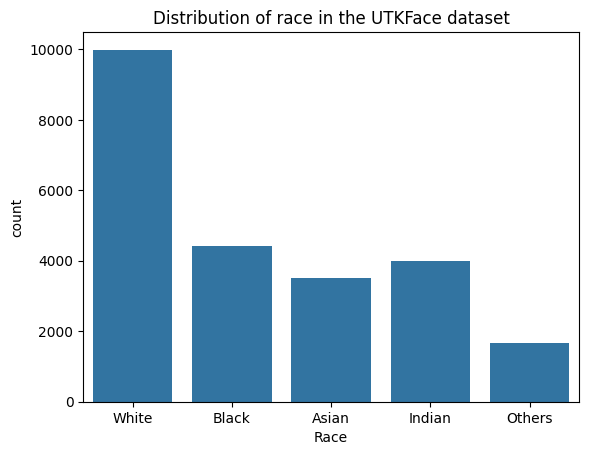

In [ ]:
# Race Mapping
race_mapping = {
    0 : 'White',
    1 : 'Black',
    2 : 'Asian',
    3 : 'Indian',
    4 : 'Others'
}

# Replacing the integers with correct race
DFrame['Race'] = DFrame['Race'].replace(race_mapping)

# Specifying the order of categories based on race_mapping
race_order = list(race_mapping.values())

# Count plot
plt.figure()
sns.countplot(x='Race', data=DFrame, order=race_order)
plt.title('Distribution of race in the UTKFace dataset')

The following code divides the age range into 5 different age categories as Child, Youth, Adult, Middle Age and Old. The age ranges of the above categories are as follows: <br>

| Age Group     | Year Range     |
|---------------|----------------|
| Child         | 0-14    |
| Youth         | 14-25   |
| Adult         | 25-40   |
| Middle Age    | 40-60   |
| Old           | 60+     |

Then, the age group distribution of the UTKFace data used in this study is shown separately and along with gender.

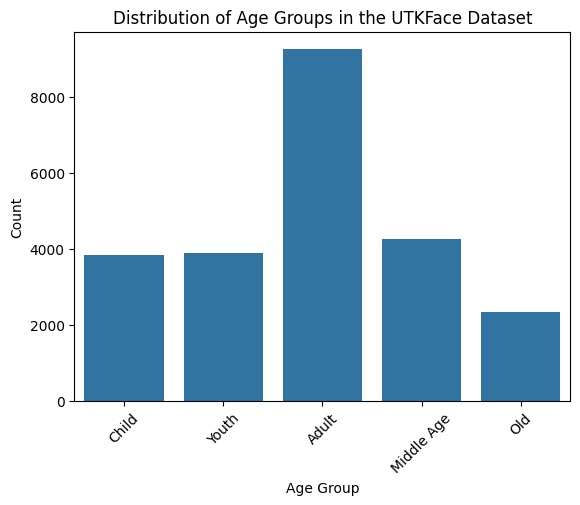

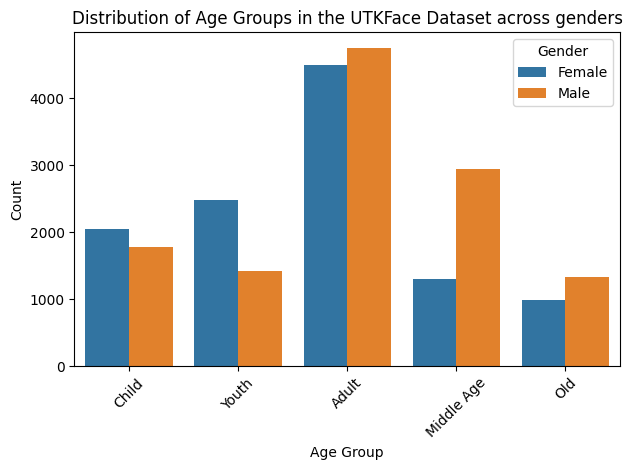

In [ ]:
# Age distribution

# Defining bins and labels
bins = [0, 14, 25, 40, 60, 116]
labels = ["Child", "Youth", "Adult", "Middle Age", "Old"]

# Classifying ages into groups
DFrame['Age_Group'] = pd.cut(DFrame['Age'], bins=bins, labels=labels, right=True)  # (0, 14], (14,25], (25, 40], (40, 60] and (60, 116]

# Plotting the distribution of age groups
fig1, ax1 = plt.subplots()
sns.countplot(x='Age_Group', data=DFrame, ax=ax1)
ax1.set_title('Distribution of Age Groups in the UTKFace Dataset')
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Count')


# Race Mapping
gender_mapping = {
    0 : 'Male',
    1 : 'Female'
}
# Replacing the integers with correct gender
DFrame['Gender'] = DFrame['Gender'].replace(gender_mapping)

# Plotting the distribution of age groups with gender
fig1, ax2 = plt.subplots()
sns.countplot(x='Age_Group', hue='Gender', data=DFrame, ax=ax2)
ax2.set_title('Distribution of Age Groups in the UTKFace Dataset across genders')
ax2.set_xlabel('Age Group')
ax2.set_ylabel('Count')

# Rotating x-tick labels for both axes
for label in ax1.get_xticklabels():
  label.set_rotation(45)  # Rotating x-tick labels by 45 degrees

for label in ax2.get_xticklabels():
  label.set_rotation(45)  # Rotating x-tick labels by 45 degrees

plt.tight_layout()
plt.show()

The following function "labeling_age_group_tf" returns the age group label given the age and a tensor called bins containing bin locations. Since the age groups are divided into 5 categories, bins = [0, 14, 25, 40, 60, 116] which indicate the boundaries of age groups. The given age is checked in each defined age group and recorded its state in a boolean tensor. The location where the boolean tensor is true gives the integer label associated with each age group.

The inter mapping of age group is as follows:

| Age Group     | Year Range     | Integer Label  |
|---------------|----------------|----------------|
| Child         | 0-14           |       0        |
| Youth         | 14-25          |       1        |
| Adult         | 25-40          |       2        |
| Middle Age    | 40-60          |       3        |
| Old           | 60+            |       4        |

In [ ]:
def labeling_age_group_tf(age, bins):
    # Converting bins and age to TensorFlow constants
    bins = tf.constant(bins, dtype=tf.int32)

    # Creating labels from 0 to len(bins) - 2
    age_groups = tf.range(len(bins) - 1, dtype=tf.int32)

    # Finding the appropriate age group
    conditions = tf.logical_and(age > bins[:-1], age <= bins[1:])
    label = tf.reduce_sum(tf.where(conditions, age_groups, 0))

    return label

Each facial image is labeled in the format  age_gender_race_date&time.jpg. The function "read_image" splits the label of an image and separately returns age group, gender and race integer labels along with the associated facial image. The function "labeling_age_group_tf" is used here to identify the age group associated with the age.

In [ ]:
def read_image(fname):
    # Extracting label from file name
    parts = tf.strings.split(fname, os.sep)
    file_name = parts[-1]
    multiple_labels = tf.strings.split(file_name, '_')

    # Converting age label to integer
    age_label = tf.strings.to_number(multiple_labels[0], out_type=tf.int32)

    # Defining age bins
    bins = [0, 14, 25, 40, 60, 116]

    # Extracting labels (age, gender, race)
    age_label =  labeling_age_group_tf(age_label, bins)  # First part: age
    gender_label = tf.strings.to_number(multiple_labels[1], out_type=tf.int32)     # Second part: gender
    race_label = tf.strings.to_number(multiple_labels[2], out_type=tf.int32)       # Third part: race

    # Converting race label to integer
    label = tf.strings.to_number(multiple_labels[2], out_type=tf.int32)

    # Loading and decoding the image
    image = tf.io.read_file(fname)
    image = tf.io.decode_jpeg(image)
    return image, age_label, gender_label, race_label

The following code preprocess each image and applies random transformations if augment is true. The images are initially normalised.
Then, if the augment argument is true, each image is augmented in following ways:
* random flip left-right
* random brightness
* random contrast
* random rotation upto 20 degrees

Finally, this function returns the preprocessed image along with its separate age group, gender and race labels.


In [ ]:
# Defining the rotation layer outside the function for reuse
rotation_layer = keras_cv.layers.RandomRotation(factor=0.111)  # 0.111 ~= 20 degrees

def preprocess_image(image, age_label, gender_label, race_label, augment):

    # Converting image to float32 and normalize to [0,1]
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)

    if augment:
        # Applying augmentation
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
        # Rotating up to 20 degrees using KerasCV
        image = rotation_layer(image)

    return image, age_label, gender_label, race_label

This below code splits a dataset of file paths into training (10%) and validation (5%) using TensorFlow's tf.data.Dataset API. It starts by listing all files in a specified folder and shuffling them for randomness with a fixed seed for reproducibility. The dataset is then divided: the first 10% of files are taken for training and the next 5% for validation.

In [ ]:
# Creating training, validation and test sets.
list_ds = tf.data.Dataset.list_files(folder_path + "/*")

# Total number of files
file_count = len(list_ds)

# Defining split sizes
train_size = int(0.10 * file_count)  # 10% for training
val_size = int(0.05 * file_count)    # 5% for validation

# Shuffling the dataset before splitting
list_ds = list_ds.shuffle(buffer_size=file_count, seed=42)

# Splitting into training, validation, and test datasets
train_list_ds = list_ds.take(train_size)               # First 10% for training
val_list_ds = list_ds.skip(train_size).take(val_size)  # Next 5% for validation

## 2. Building a CNN using Transfer Learning on VGG16
Input image shape: (100, 100, 3)

In [ ]:
class CombinedAccuracyCallback(keras.callbacks.Callback):
  def __init__(self, checkpoint_path):
    super().__init__()
    self.best_accuracy = 0  # Initializing the best validation accuracy as 0
    self.best_loss = float('inf')  # Initializing the best validation loss
    self.checkpoint_path = checkpoint_path  # Path to save the best model
    self.train_accuracies = []  # List to store combined training accuracies
    self.val_accuracies = []    # List to store combined validation accuracies
    self.train_losses = []      # List to store combined training losses
    self.val_losses = []        # List to store combined validation losses

  def on_epoch_end(self, epoch, logs=None):
    # Calculating combined training accuracy
    combined_train_accuracy = (
        0.4 * logs.get('age_output_accuracy', 0) +
        0.2 * logs.get('gender_output_accuracy', 0) +
        0.4 * logs.get('race_output_accuracy', 0)
    )
    # Calculating combined validation accuracy
    combined_val_accuracy = (
        0.4 * logs.get('val_age_output_accuracy', 0) +
        0.2 * logs.get('val_gender_output_accuracy', 0) +
        0.4 * logs.get('val_race_output_accuracy', 0)
    )
    # Calculating combined training loss
    combined_train_loss = (
        0.4 * logs.get('age_output_loss', 0) +
        0.2 * logs.get('gender_output_loss', 0) +
        0.4 * logs.get('race_output_loss', 0)
    )
    # Calculating combined validation loss
    combined_val_loss = (
        0.4 * logs.get('val_age_output_loss', 0) +
        0.2 * logs.get('val_gender_output_loss', 0) +
        0.4 * logs.get('val_race_output_loss', 0)
    )

    print(f"Epoch {epoch + 1}: Combined Training Accuracy = {combined_train_accuracy:.4f}, Combined Validation Accuracy = {combined_val_accuracy:.4f}, Combined Training Loss = {combined_train_loss:.4f}, Combined Validation Loss = {combined_val_loss:.4f}")

    # Save metrics
    self.train_accuracies.append(combined_train_accuracy)
    self.val_accuracies.append(combined_val_accuracy)
    self.train_losses.append(combined_train_loss)
    self.val_losses.append(combined_val_loss)

    # Saving the model if combined validation accuracy improves
    if combined_val_accuracy > self.best_accuracy:
      print(f"New best combined accuracy! Saving model to {self.checkpoint_path}")
      self.best_accuracy = combined_val_accuracy
      self.model.save(self.checkpoint_path)  # Saving the model
    else:
      print("Combined validation accuracy did not improve.")

  def on_train_end(self, logs=None):
   self.history = {
       'combined_train_acc': self.train_accuracies,
       'combined_val_acc': self.val_accuracies,
       'combined_train_loss': self.train_losses,
       'combined_val_loss': self.val_losses
   }

This code runs in a couple of loops to find the best combination of batch size and learning rate that provide the highest validation accuracy. This grid serach looks thorough batch sizes [16, 32, 64, 128] and learning rates [1e-6, 1e-5, 1e-4, 1e-3] over a 10 epoch period.

The training and validation datasets are subsets of datasets (10% and 5%) used for hyper-parameter tuning. Each subset is prepared by mapping file paths to images using read_image, followed by applying preprocessing with preprocess_image with data augmentation. Labels for age, gender, and race are formatted into a dictionary with keys age_output, gender_output, and race_output. The datasets are batched for each batch size, cached for faster reuse, and prefetched to improve performance by preparing the next batch while the current one is being processed. The use of tf.data.AUTOTUNE optimizes parallelism and performance. Then for each batch size, specified learning rates are looped through and validation accuracies of all models are recorded. The optimal model has the highest validation accuracy.

This multi-task deep learning model is designed for simultaneous gender, age group, and race classifications. The input is an image of shape (100, 100, 3). It begins by creating a convolutional neural network (CNN) based on a modified VGG16 architecture (Simonyan and Zisserman, 2015). This model has a VGG convolutional base with five blocks, each containing multiple convolutional layers followed by max-pooling to progressively extract spatial features while reducing dimensionality. This VGG convolutional base, trained on ImageNet (Deng, 2009) is then connected to three separate fully connected (FC) layers and the repective output layers to achieve the multiple classifications. Through transfer learning, the weights of trained model on ImageNet is loaded to the convolutional base and made it fully frozen except block 5. All FCs and block 5 of the VGG base are allowed to train. <br>


Model Summary: <br>
Running frozen VGG16 (except block 5) conv base + 3 x {[128] FC layer + [out layer]} for age group, gender and race classifications for tuning of hyper-parameters such as batch size and learning rate. Here, the out layer has 2, 5, 5 nodes for gender, age group and race classifications respectively.

In [ ]:
from tensorflow.keras.applications import vgg16
seed = 42
set_random_seed(seed)
np.random.seed(42)
combined_loss = []
combined_val_loss = []
combined_accuracy = []
combined_val_accuracy = []
evaluation_results = []
batch_sizes =  [16, 32, 64, 128]
learning_rates = [1e-6, 1e-5, 1e-4, 1e-3]
para_combinations = []

# Load the vgg16 model with pre-trained ImageNet weights and without the top classification layer
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

no = 0
for batch_size in batch_sizes:
  # Dataset preparation with preprocessing
  train_ds = (
      train_list_ds
      .map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
      .map(lambda img, age_label, gender_label, race_label:
          preprocess_image(img, age_label, gender_label, race_label, augment=True),  # Applying preprocessing with augmentation
          num_parallel_calls=tf.data.AUTOTUNE)
      .map(lambda img, age_label, gender_label, race_label:
          (img, {'age_output': age_label, 'gender_output': gender_label, 'race_output': race_label}),  # Formatting the labels
          num_parallel_calls=tf.data.AUTOTUNE)
      .batch(batch_size)
      .cache()
      .prefetch(tf.data.AUTOTUNE)
            )

  val_ds = (
      val_list_ds
      .map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
      .map(lambda img, age_label, gender_label, race_label:
          preprocess_image(img, age_label, gender_label, race_label, augment=False),  # Applying preprocessing without augmentation
          num_parallel_calls=tf.data.AUTOTUNE)
      .map(lambda img, age_label, gender_label, race_label:
          (img, {'age_output': age_label, 'gender_output': gender_label, 'race_output': race_label}),  # Formatting the labels
          num_parallel_calls=tf.data.AUTOTUNE)
      .batch(batch_size)
      .cache()
      .prefetch(tf.data.AUTOTUNE)
           )

  # Preloading datasets by iterating through them once
  print(f"Preloading training dataset with batch_size = {batch_size}...")
  for _ in train_ds:
    pass  # This ensures the entire training dataset is cached
  print(f"Preloading validation dataset with batch_size = {batch_size}...")
  for _ in val_ds:
    pass  # This ensures the entire validation dataset is cached
  print("Datasets preloaded successfully!")

  for lr in learning_rates:
    seed = 42
    set_random_seed(seed)
    np.random.seed(42)

    # Clone the base model
    cl_base = models.clone_model(base_model)
    cl_base.set_weights(base_model.get_weights())

    for layer in cl_base.layers[:15]:
      layer.trainable = False

    flatten = layers.GlobalAveragePooling2D()(cl_base.output)

    # Gender classification
    gender = layers.Dense(128, activation='relu', name='gender_fc1')(flatten)
    gender_out = layers.Dense(2, activation='softmax', name='gender_output')(gender)

    # Age group classification
    age_group = layers.Dense(128, activation='relu', name='age_fc1')(flatten)
    age_out = layers.Dense(5, activation='softmax', name='age_output')(age_group)

    # Race classifaction
    race = layers.Dense(128, activation='relu', name='race_fc1')(flatten)
    race_out = layers.Dense(5, activation='softmax', name='race_output')(race)

    # Multi-task model
    model = models.Model(inputs=cl_base.input, outputs=[age_out, gender_out, race_out], name='multi_task_model')

    # Creating the checkpoint callback
    checkpoint_path = "/content/drive/My Drive/checkpoint/weights.keras"
    #mc_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')
    combined_accuracy_callback = CombinedAccuracyCallback(checkpoint_path)

    # Compiling the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0),
        loss={
            'age_output': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            'gender_output': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            'race_output': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        },

        loss_weights={
            'age_output': 0.4,
            'gender_output': 0.2,
            'race_output': 0.4,
        },

        metrics={
            'age_output': ['accuracy'],
            'gender_output': ['accuracy'],
            'race_output': ['accuracy'],
        }
    )
    # My model’s last layer has a softmax activation, thus from_logits=False

    print(f"\n***** Training a multi-task learning based VGG model with batch_size = {batch_size} and learning_rate = {lr} *****")
    history = model.fit(
                      train_ds,
                      epochs=10,
                      validation_data=val_ds,
                      batch_size=batch_size,
                      callbacks=[combined_accuracy_callback],
                      verbose=2
                     )
    # My model’s last layer has a softmax activation, thus from_logits=False

    combined_loss.append(history.history['loss'])
    combined_val_loss.append(history.history['val_loss'])
    combined_accuracy.append(combined_accuracy_callback.history['combined_train_acc'])
    combined_val_accuracy.append(combined_accuracy_callback.history['combined_val_acc'])

    para_combinations.append(f'model_{no}_lr_{lr}_batchSize_{batch_size}')
    no = no + 1
    # Loading the weights of the model with the best validation accuracy
    model.load_weights(checkpoint_path)
    # Evaluating the model on the test dataset
    evaluation_results.append(model.evaluate(val_ds, verbose=2))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Preloading training dataset with batch_size = 16...
Preloading validation dataset with batch_size = 16...
Datasets preloaded successfully!

***** Training a multi-task learning based VGG model with batch_size = 16 and learning_rate = 1e-06 *****
Epoch 1/10
Epoch 1: Combined Training Accuracy = 0.2469, Combined Validation Accuracy = 0.2428, Combined Training Loss = 0.6227, Combined Validation Loss = 0.5701
New best combined accuracy! Saving model to /content/drive/My Drive/checkpoint/weights.keras
148/148 - 27s - 184ms/step - age_output_accuracy: 0.1702 - age_output_loss: 0.7083 - gender_output_accuracy: 0.4856 - gender_output_loss: 0.1532 - loss: 1.6337 - race_output_accuracy: 0.2042 - race_output_loss: 0.7719 - val_age_output_accuracy: 0.1723 - val_age_output_loss: 0.6719 - val_gender_output_accuracy: 0.4652 - val_gender_output_loss: 0.1452 - val_loss: 1.4984 - val_race_output_accuracy: 0.2020 - val_race_output_loss: 0.6808
Epoch 2/10

**Identifying the hyper-paratemers of the model with the highest combined validation accuracy.**

In [ ]:
# best model
val_acc= np.max(np.array(combined_val_accuracy), axis=1)
ind, val = np.argmax(val_acc), np.max(val_acc)
print(f"model_id = {ind}, Best val_accuracy = {val}")
print(f"para_combinations = {para_combinations[ind]}")

model_id = 6, Best val_accuracy = 0.6845500826835633
para_combinations = model_6_lr_0.0001_batchSize_32


**Summary of combined validation accuracies of all models with different batch sizes and learning rates.**

In [ ]:
batch_sizes = [16, 32, 64, 128]
learning_rates = [1e-6, 1e-5, 1e-4, 1e-3]
val_acc = val_acc.reshape(4,4)

dframe1 = pd.DataFrame(val_acc)
dframe1.columns = ['1e-6', '1e-5', '1e-4', '1e-3']
dframe1.index = [16, 32, 64, 128]
dframe1

,1e-6,1e-5,1e-4,1e-3
16,0.536503,0.654499,0.650085,0.631070
32,0.523260,0.676061,0.684550,0.649066
64,0.464007,0.638370,0.668082,0.659762
128,0.430560,0.633786,0.676401,0.666214


**Plotting the batch sizes, learning rates and the combined validation accuracies in the 3D plot for better visualisation.**

In [ ]:
import plotly.graph_objects as go

# Define parameters
batch_sizes = [16, 32, 64, 128]
learning_rates = [1e-6, 1e-5, 1e-4, 1e-3]

# Create the meshgrid
batch_sizes_grid, learning_rates_grid = np.meshgrid(batch_sizes, learning_rates)
val_acc = np.transpose(val_acc)

# Reshape val_acc to match the grid
val_acc_grid = val_acc.reshape(len(learning_rates), len(batch_sizes))

# Find the maximum value and its indices
max_val = np.max(val_acc)
max_idx = np.unravel_index(np.argmax(val_acc), val_acc_grid.shape)
max_batch_size = batch_sizes_grid[max_idx]
max_learning_rate = learning_rates_grid[max_idx]

# Create a Plotly Surface plot
fig = go.Figure(data=[
    go.Surface(
        z=val_acc_grid,
        x=batch_sizes_grid,
        y=learning_rates_grid,
        colorscale='Viridis',
        colorbar=dict(title='Validation Accuracy')
    ),
    # Add a Scatter3d point for the maximum value
    go.Scatter3d(
        x=[max_batch_size],
        y=[max_learning_rate],
        z=[max_val],
        mode='markers+text',
        marker=dict(size=10, color='red'),
        text=[f'Max: {max_val:.2f}, lr: {max_learning_rate}, batch_size={max_batch_size}'],
        textposition='top center'
    )
])

# Update layout for better readability
fig.update_layout(
    title='Validation Accuracy 3D Surface Plot with Maximum Value',
    scene=dict(
        xaxis_title='Batch Size',
        yaxis_title='Learning Rate',
        zaxis_title='Validation Accuracy',
        #xaxis=dict(type='log'),
        yaxis=dict(type='log')
    ),
    width=800,
    height=700
)

# Show the plot
fig.show()


## References

Deng, J., Dong, W., Socher, R., Li, L. J., Li, K., and Fei-Fei, L., "ImageNet: A large-scale hierarchical image database," IEEE Conference on Computer Vision and Pattern Recognition, Miami, FL, USA, 2009, pp. 248-255, doi: 10.1109/CVPR.2009.5206848.

Simonyan, K. and Zisserman, A. (2015). Very Deep Convolutional Networks for Large-Scale Image Recognition. In: Proceedings of the International Conference on Learning Representations (ICLR). ICLR. Available at: https://arxiv.org/abs/1409.1556.